# pymo 테스트 코드

In [7]:
# Read BVH Files
from pymo.parsers import BVHParser

parser = BVHParser()

bvh_file_path = '/home/maeng/In-HARD/Online/Skeleton/P01_R01.bvh'  # <-- 원본 .bvh 파일 경로를 입력하세요

parsed_data = parser.parse(bvh_file_path)

In [8]:
# Get Skeleton Info
from pymo.viz_tools import *

print_skel(parsed_data)

- Hips (None)
| | - Spine (Hips)
| | - Spine1 (Spine)
| | - Spine2 (Spine1)
| | - Spine3 (Spine2)
| | | | - LeftShoulder (Spine3)
| | | | - LeftArm (LeftShoulder)
| | | | - LeftForeArm (LeftArm)
| | | | - LeftHand (LeftForeArm)
| | | | | | | | - LeftInHandPinky (LeftHand)
| | | | | | | | - LeftHandPinky1 (LeftInHandPinky)
| | | | | | | | - LeftHandPinky2 (LeftHandPinky1)
| | | | | | | | - LeftHandPinky3 (LeftHandPinky2)
| | | | | | | | - LeftHandPinky3_Nub (LeftHandPinky3)
| | | | | | | - LeftInHandRing (LeftHand)
| | | | | | | - LeftHandRing1 (LeftInHandRing)
| | | | | | | - LeftHandRing2 (LeftHandRing1)
| | | | | | | - LeftHandRing3 (LeftHandRing2)
| | | | | | | - LeftHandRing3_Nub (LeftHandRing3)
| | | | | | - LeftInHandMiddle (LeftHand)
| | | | | | - LeftHandMiddle1 (LeftInHandMiddle)
| | | | | | - LeftHandMiddle2 (LeftHandMiddle1)
| | | | | | - LeftHandMiddle3 (LeftHandMiddle2)
| | | | | | - LeftHandMiddle3_Nub (LeftHandMiddle3)
| | | | | - LeftInHandIndex (LeftHand)
| | | | | - L

In [9]:
# scikit-learn Pipeline API
from pymo.preprocessing import *
from sklearn.pipeline import Pipeline

data_pipe = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

piped_data = data_pipe.fit_transform([parsed_data])

/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/s

In [10]:
# Convert to Positions
mp = MocapParameterizer('position')

positions = mp.fit_transform([parsed_data])

/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/s

<Axes: >

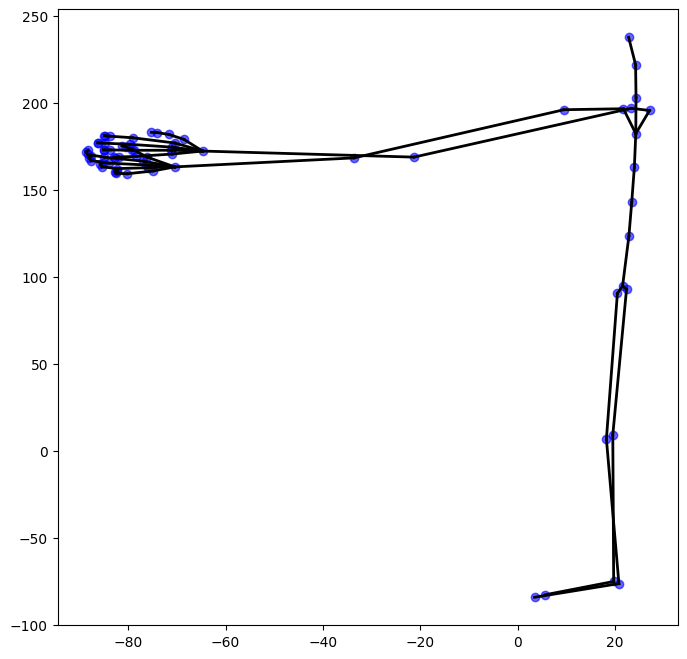

In [11]:
# Visualize a single 2D Frame
draw_stickfigure(positions[0], frame=10)

In [12]:
# Animate in 3D (inside a Jupyter Notebook)
nb_play_mocap(positions[0], 'pos', 
              scale=2, camera_z=800, frame_time=1/120, 
              base_url='pymo/mocapplayer/playBuffer.html')

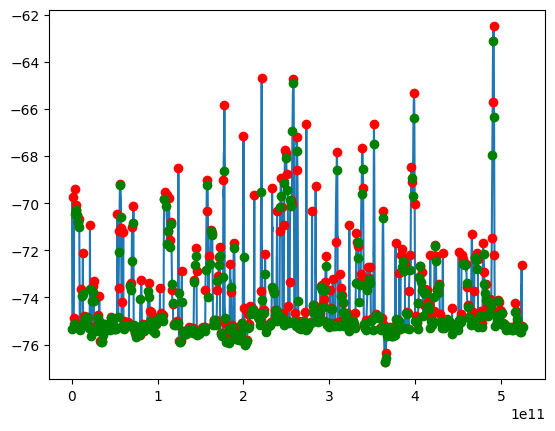

In [16]:
# Foot/Ground Contact Detector
from pymo.features import *

plot_foot_up_down(positions[0], 'RightFoot_Yposition')

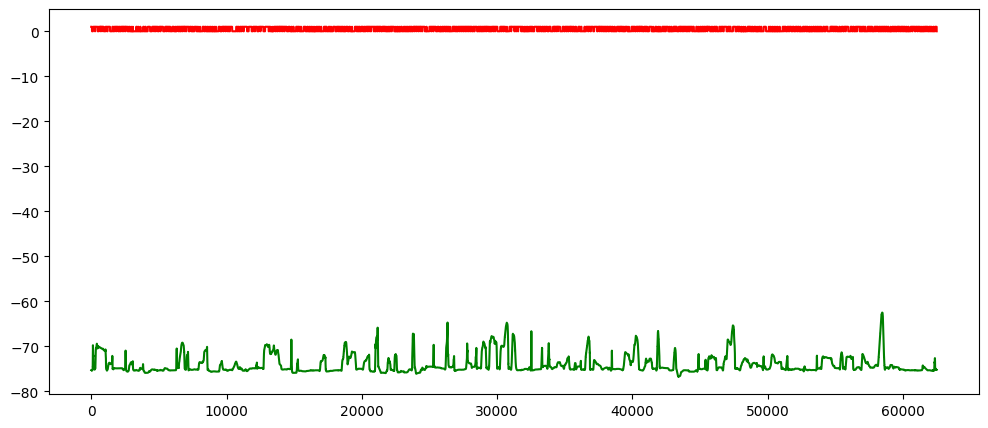

In [17]:
signal = create_foot_contact_signal(positions[0], 'RightFoot_Yposition')
plt.figure(figsize=(12,5))
plt.plot(signal, 'r')
plt.plot(positions[0].values['RightFoot_Yposition'].values, 'g')

# 지희님 work-flow follow-up

In [2]:
import numpy as np
import pandas as pd
from pymo.parsers import BVHParser
from pymo.preprocessing import MocapParameterizer
from scipy.spatial.distance import euclidean

In [3]:
# 1. BVH 파일 파싱
BVH_FILE_PATH = '/home/maeng/In-HARD/Online/Skeleton/P01_R01.bvh'  # <-- 원본 .bvh 파일 경로를 입력하세요

# 프레임 번호를 매핑하는 CSV 파일의 고정 경로
MAPPING_CSV_PATH = "/home/maeng/In-HARD/Online/InHARD.csv" 

parser = BVHParser()
parsed_data = parser.parse(BVH_FILE_PATH)

# BVH 같은 모션 캡처 데이터의 **Forward Kinematics (FK, 순방향 운동학)**를 계산하여 각 관절(joint)의 **월드 좌표계(world coordinate) 상의 3D 위치(position)**를 얻기 위해 사용
fk_calculator = MocapParameterizer('position')
global_positions_mocapdata = fk_calculator.fit_transform([parsed_data])[0]

global_positions_mocapdata

/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/s

In [4]:
world_column_names = [f"{jn}_{ax}position" for jn in parsed_data.skeleton.keys() for ax in ['X', 'Y', 'Z']]
len(world_column_names), world_column_names

(216,
 ['Hips_Xposition',
  'Hips_Yposition',
  'Hips_Zposition',
  'RightUpLeg_Xposition',
  'RightUpLeg_Yposition',
  'RightUpLeg_Zposition',
  'RightLeg_Xposition',
  'RightLeg_Yposition',
  'RightLeg_Zposition',
  'RightFoot_Xposition',
  'RightFoot_Yposition',
  'RightFoot_Zposition',
  'RightFoot_Nub_Xposition',
  'RightFoot_Nub_Yposition',
  'RightFoot_Nub_Zposition',
  'LeftUpLeg_Xposition',
  'LeftUpLeg_Yposition',
  'LeftUpLeg_Zposition',
  'LeftLeg_Xposition',
  'LeftLeg_Yposition',
  'LeftLeg_Zposition',
  'LeftFoot_Xposition',
  'LeftFoot_Yposition',
  'LeftFoot_Zposition',
  'LeftFoot_Nub_Xposition',
  'LeftFoot_Nub_Yposition',
  'LeftFoot_Nub_Zposition',
  'Spine_Xposition',
  'Spine_Yposition',
  'Spine_Zposition',
  'Spine1_Xposition',
  'Spine1_Yposition',
  'Spine1_Zposition',
  'Spine2_Xposition',
  'Spine2_Yposition',
  'Spine2_Zposition',
  'Spine3_Xposition',
  'Spine3_Yposition',
  'Spine3_Zposition',
  'Neck_Xposition',
  'Neck_Yposition',
  'Neck_Zposition',
 

In [5]:
global_positions_df = pd.DataFrame(global_positions_mocapdata.values, columns=world_column_names)
global_positions_df.head()

,Hips_Xposition,Hips_Yposition,Hips_Zposition,RightUpLeg_Xposition,RightUpLeg_Yposition,RightUpLeg_Zposition,RightLeg_Xposition,RightLeg_Yposition,RightLeg_Zposition,RightFoot_Xposition,...,LeftHandPinky1_Zposition,LeftHandPinky2_Xposition,LeftHandPinky2_Yposition,LeftHandPinky2_Zposition,LeftHandPinky3_Xposition,LeftHandPinky3_Yposition,LeftHandPinky3_Zposition,LeftHandPinky3_Nub_Xposition,LeftHandPinky3_Nub_Yposition,LeftHandPinky3_Nub_Zposition
0 days 00:00:00,20.925001,94.647675,23.358198,21.669570,92.738689,4.654250,18.979635,9.055388,4.736655,19.634225,...,-20.364799,-81.539362,162.022999,-25.063413,-82.131389,163.014411,-28.350377,-81.892675,163.709184,-29.822223
0 days 00:00:00.008401113,21.054373,94.653931,23.394234,21.798056,92.746262,4.694404,19.102978,9.061261,4.779018,19.641193,...,-19.760567,-82.512763,162.958013,-24.459000,-83.104921,163.949648,-27.745873,-82.866252,164.644496,-29.217691
0 days 00:00:00.016802227,21.141069,94.663101,23.365467,21.889357,92.754404,4.659537,19.168213,9.067327,4.743949,19.634620,...,-23.069225,-78.790889,163.505070,-28.132683,-78.825069,164.679573,-31.412454,-78.337815,165.440708,-32.786966
0 days 00:00:00.025203340,21.217239,94.664818,23.341904,21.967136,92.757313,4.645790,19.214295,9.067925,4.702120,19.626080,...,-21.435332,-79.677933,163.741889,-26.534147,-79.644971,164.958384,-29.798589,-79.131320,165.739936,-31.151868
0 days 00:00:00.033604454,21.252237,94.668900,23.341755,22.014346,92.763535,4.643199,19.211743,9.072451,4.707033,19.608191,...,-19.869126,-79.441931,162.174140,-24.854308,-79.634553,163.313665,-28.140934,-79.221079,164.072591,-29.540611


In [6]:
is_yposition_column  = global_positions_mocapdata.values.columns.str.contains('Yposition')
y_positions_df = global_positions_mocapdata.values.loc[:, is_yposition_column]
y_positions_df.head()

,Hips_Yposition,Spine_Yposition,Spine1_Yposition,Spine2_Yposition,Spine3_Yposition,LeftShoulder_Yposition,LeftArm_Yposition,LeftForeArm_Yposition,LeftHand_Yposition,LeftInHandPinky_Yposition,...,Head_Yposition,Head_Nub_Yposition,LeftUpLeg_Yposition,LeftLeg_Yposition,LeftFoot_Yposition,LeftFoot_Nub_Yposition,RightUpLeg_Yposition,RightLeg_Yposition,RightFoot_Yposition,RightFoot_Nub_Yposition
0 days 00:00:00,94.647675,123.151887,142.560577,162.770086,182.094077,196.382251,196.025271,166.814402,165.672692,163.266732,...,221.613974,237.454163,90.228285,6.562864,-76.524874,-84.376378,92.738689,9.055388,-75.254968,-82.918168
0 days 00:00:00.008401113,94.653931,123.157840,142.559736,162.768029,182.090008,196.357247,196.040209,167.262584,166.606154,164.200681,...,221.612676,237.452864,90.232290,6.564662,-76.520269,-84.372078,92.746262,9.061261,-75.249993,-82.913193
0 days 00:00:00.016802227,94.663101,123.167180,142.573602,162.781564,182.103022,196.400146,196.032085,168.164439,165.983471,163.940586,...,221.617101,237.459165,90.234998,6.563311,-76.514205,-84.365795,92.754404,9.067327,-75.241767,-82.909434
0 days 00:00:00.025203340,94.664818,123.168905,142.583896,162.792818,182.118526,196.433161,195.699168,168.724168,166.063321,164.062449,...,221.631349,237.473493,90.229549,6.555239,-76.515575,-84.367588,92.757313,9.067925,-75.238428,-82.906385
0 days 00:00:00.033604454,94.668900,123.172617,142.590916,162.799034,182.127152,196.441109,195.640648,168.319219,165.103911,162.906921,...,221.642618,237.487528,90.233144,6.556991,-76.510361,-84.360778,92.763535,9.072451,-75.233809,-82.899296


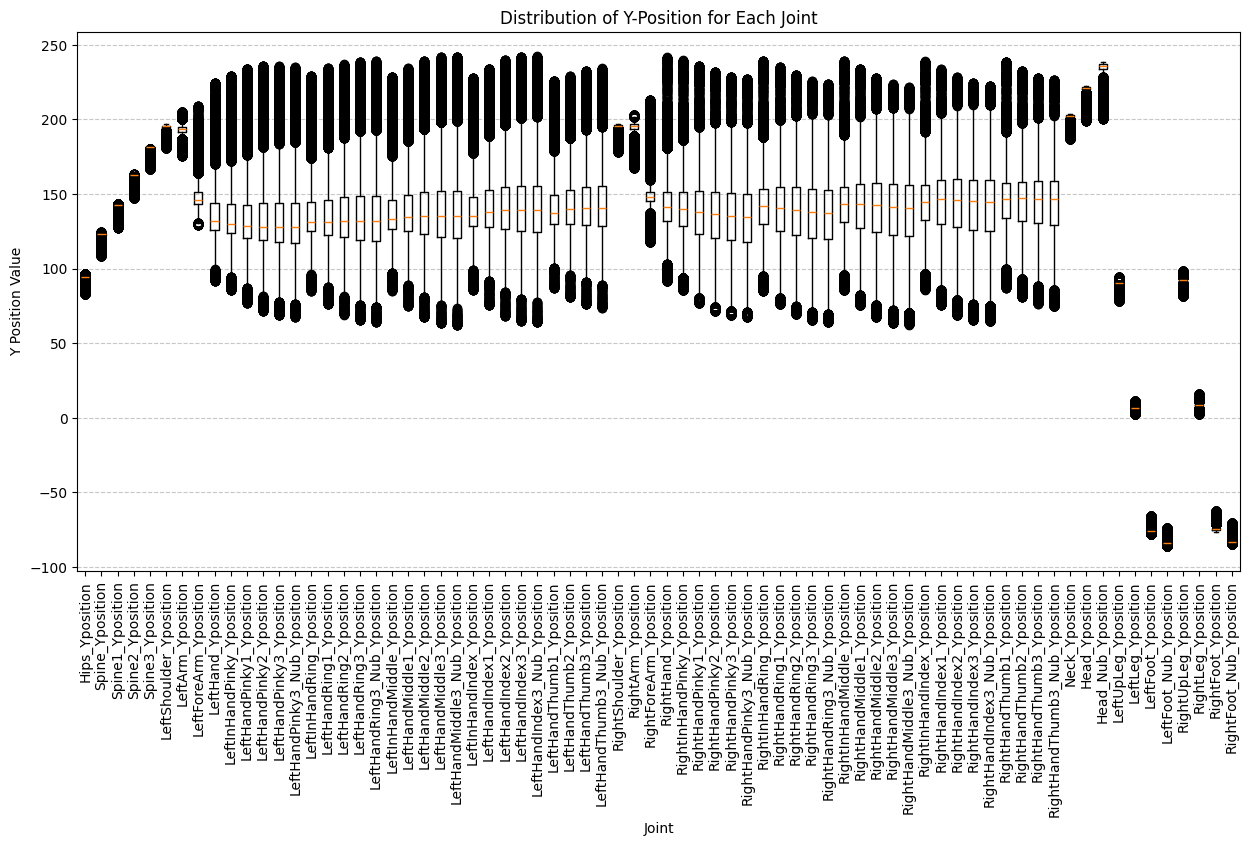

In [22]:
import matplotlib.pyplot as plt

# 1. 그래프 사이즈 조절 (컬럼이 많을 경우를 대비)
plt.figure(figsize=(15, 7))

# 2. 박스플롯 그리기
# DataFrame을 직접 전달하면 각 컬럼을 하나의 박스플롯으로 그립니다.
plt.boxplot(y_positions_df)

# 3. X축 레이블 설정
# 컬럼 이름들이 x축의 각 눈금이 되도록 설정하고, 90도 회전시켜 겹치지 않게 합니다.
plt.xticks(ticks=range(1, len(y_positions_df.columns) + 1), 
           labels=y_positions_df.columns, 
           rotation=90)

# 4. 제목 및 라벨 추가
plt.title('Distribution of Y-Position for Each Joint')
plt.ylabel('Y Position Value')
plt.xlabel('Joint')
plt.grid(True, axis='y', linestyle='--', alpha=0.7) # y축 그리드 추가

# 5. 그래프 출력
plt.show()

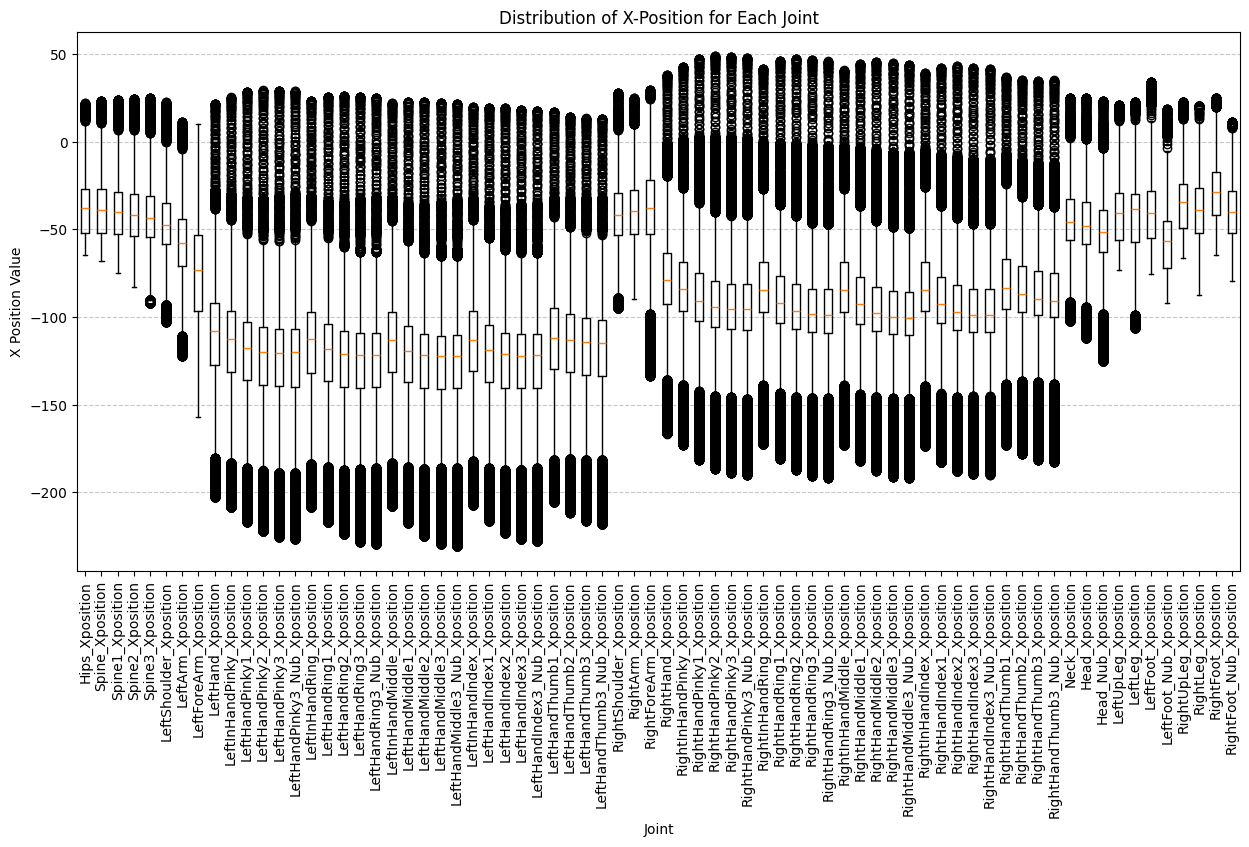

In [23]:
is_yposition_column  = global_positions_mocapdata.values.columns.str.contains('Xposition')
y_positions_df = global_positions_mocapdata.values.loc[:, is_yposition_column]
y_positions_df.head()

# 1. 그래프 사이즈 조절 (컬럼이 많을 경우를 대비)
plt.figure(figsize=(15, 7))

# 2. 박스플롯 그리기
# DataFrame을 직접 전달하면 각 컬럼을 하나의 박스플롯으로 그립니다.
plt.boxplot(y_positions_df)

# 3. X축 레이블 설정
# 컬럼 이름들이 x축의 각 눈금이 되도록 설정하고, 90도 회전시켜 겹치지 않게 합니다.
plt.xticks(ticks=range(1, len(y_positions_df.columns) + 1), 
           labels=y_positions_df.columns, 
           rotation=90)

# 4. 제목 및 라벨 추가
plt.title('Distribution of X-Position for Each Joint')
plt.ylabel('X Position Value')
plt.xlabel('Joint')
plt.grid(True, axis='y', linestyle='--', alpha=0.7) # y축 그리드 추가

# 5. 그래프 출력
plt.show()

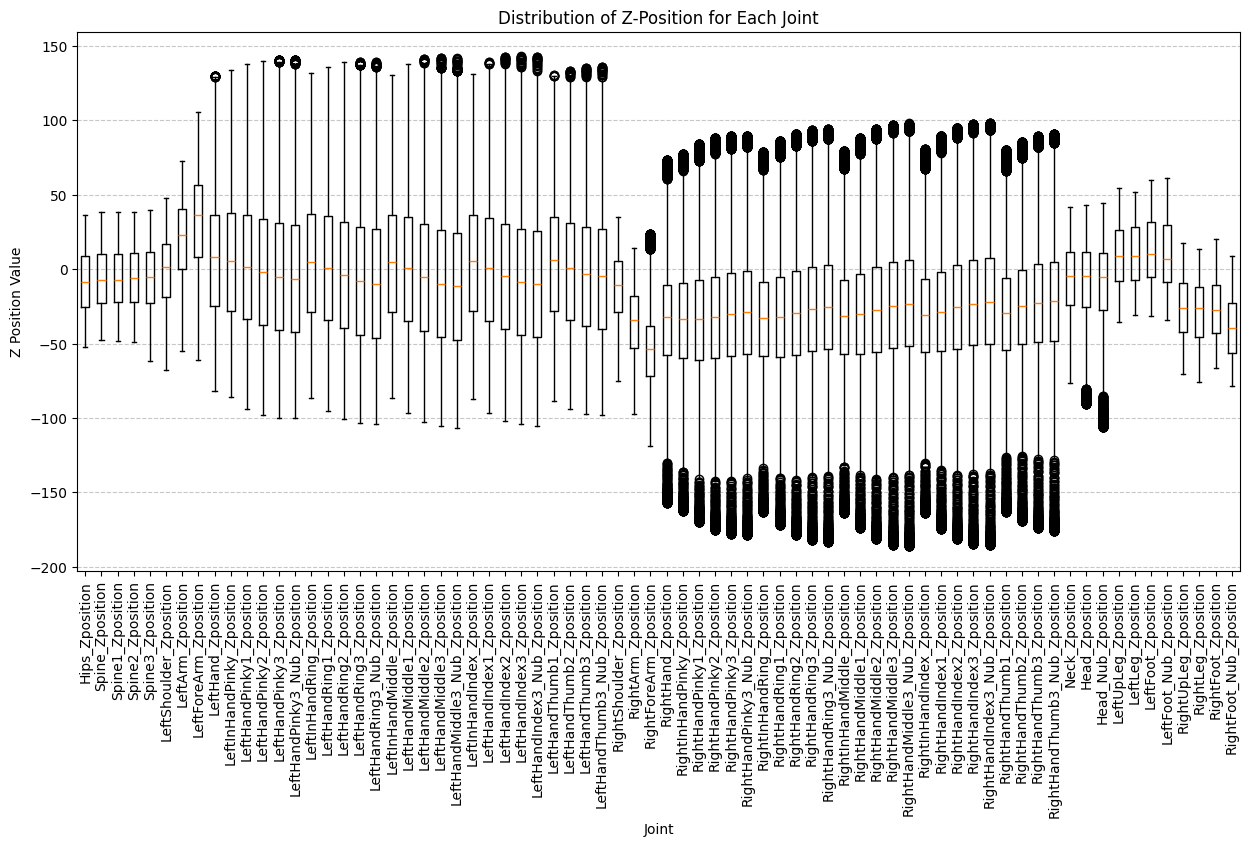

In [24]:
is_yposition_column  = global_positions_mocapdata.values.columns.str.contains('Zposition')
y_positions_df = global_positions_mocapdata.values.loc[:, is_yposition_column]
y_positions_df.head()

# 1. 그래프 사이즈 조절 (컬럼이 많을 경우를 대비)
plt.figure(figsize=(15, 7))

# 2. 박스플롯 그리기
# DataFrame을 직접 전달하면 각 컬럼을 하나의 박스플롯으로 그립니다.
plt.boxplot(y_positions_df)

# 3. X축 레이블 설정
# 컬럼 이름들이 x축의 각 눈금이 되도록 설정하고, 90도 회전시켜 겹치지 않게 합니다.
plt.xticks(ticks=range(1, len(y_positions_df.columns) + 1), 
           labels=y_positions_df.columns, 
           rotation=90)

# 4. 제목 및 라벨 추가
plt.title('Distribution of Z-Position for Each Joint')
plt.ylabel('Z Position Value')
plt.xlabel('Joint')
plt.grid(True, axis='y', linestyle='--', alpha=0.7) # y축 그리드 추가

# 5. 그래프 출력
plt.show()

In [7]:
# --- 3단계: 사용자 입력 (CSV 파일에 있는 RGB 프레임 번호 지정) ---
START_RGB_FRAME = 699
END_RGB_FRAME = 762

In [8]:
mapping_df = pd.read_csv(MAPPING_CSV_PATH)

# 1. CSV 파일에서 입력된 RGB 프레임 번호에 해당하는 행 탐색
start_row = mapping_df[mapping_df['Action_start_rgb_frame'] == START_RGB_FRAME]
end_row = mapping_df[mapping_df['Action_end_rgb_frame'] == END_RGB_FRAME]

if start_row.empty or end_row.empty:
    print(f"❌ 오류: CSV 파일에서 시작 프레임({START_RGB_FRAME}) 또는 종료 프레임({END_RGB_FRAME})을 찾을 수 없습니다.")

start_row, end_row

(   Action_end_bvh_frame  Action_end_rgb_frame  Action_end_rgb_sec  \
 3                  3028                   762               25.44   
 
                    Action_label  Action_start_bvh_frame  \
 3  [OP010] Catch Fixation FIXA1                    2776   
 
    Action_start_rgb_frame  Action_start_rgb_sec  Duration_sec     File  \
 3                     699                 23.32          2.12  P01_R01   
 
    Meta_action_class_number Meta_action_label Operation Recurrence Subject  
 3                         6  Picking in front     OP010        R01     P01  ,
       Action_end_bvh_frame  Action_end_rgb_frame  Action_end_rgb_sec  \
 3                     3028                   762               25.44   
 4223                  3029                   762               25.44   
 
                       Action_label  Action_start_bvh_frame  \
 3     [OP010] Catch Fixation FIXA1                    2776   
 4223    [OP010] Take measuring rod                    2863   
 
       Action_s

In [10]:
# 2. 해당 행에서 BVH 프레임 번호 추출
pick_bvh_frame = int(start_row['Action_start_bvh_frame'].iloc[0])
place_bvh_frame = int(end_row['Action_end_bvh_frame'].iloc[0])

print("-" * 50)
print(f"✔️ RGB Frame {START_RGB_FRAME} -> BVH Frame {pick_bvh_frame} (Pick)")
print(f"✔️ RGB Frame {END_RGB_FRAME} -> BVH Frame {place_bvh_frame} (Place)")
print("-" * 50)

--------------------------------------------------
✔️ RGB Frame 699 -> BVH Frame 2776 (Pick)
✔️ RGB Frame 762 -> BVH Frame 3028 (Place)
--------------------------------------------------


In [ ]:
for method_name in dir(parsed_data):
    if not method_name.startswith('_'):
        print(method_name)

parsed_data.framerate

channel_names
clone
framerate
get_all_channels
get_constant_channels
get_empty_channels
get_skeleton_tree
root_name
skeleton
traverse
values


0.008401113493104661

In [19]:
dataframe = skeleton_df = global_positions_df
frame_number = pick_bvh_frame
smoothing_window = 10

if frame_number >= len(dataframe):
    print(f"❌ 오류: BVH 프레임 {frame_number}는 존재하지 않습니다. (최대: {len(dataframe)-1})")

# 노이즈 감소: 대상 프레임 주변의 평균을 계산할 범위 설정
start_idx = max(0, frame_number - smoothing_window // 2)
end_idx = min(len(dataframe), frame_number + smoothing_window // 2)

# 1. 'Hips' 관절의 평균 위치를 가져와 몸통의 기준으로 사용
hips_pos = dataframe.iloc[start_idx:end_idx][['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition']].mean().values

In [20]:
# 2. 왼손과 오른손의 평균 위치 계산
left_hand_pos = dataframe.iloc[start_idx:end_idx][['LeftHand_Xposition', 'LeftHand_Yposition', 'LeftHand_Zposition']].mean().values
right_hand_pos = dataframe.iloc[start_idx:end_idx][['RightHand_Xposition', 'RightHand_Yposition', 'RightHand_Zposition']].mean().values

left_hand_pos, right_hand_pos

(array([-78.13965277, 130.1608525 ,  77.30218912]),
 array([-139.42065564,  191.17436868,   45.05538348]))

In [21]:
# 3. 각 손과 Hips(몸의 중심) 간의 유클리드 거리 계산
dist_left = euclidean(hips_pos, left_hand_pos)
dist_right = euclidean(hips_pos, right_hand_pos)

dist_left, dist_right

(80.38012146334803, 151.73044785936838)

In [22]:
if dist_left > dist_right:
    active_hand_name = 'LeftHand'
    object_position = left_hand_pos
else:
    active_hand_name = 'RightHand'
    object_position = right_hand_pos

active_hand_name, object_position

('RightHand', array([-139.42065564,  191.17436868,   45.05538348]))

In [23]:
def get_object_position_at_frame(dataframe, frame_number, smoothing_window=10):
    """
    지정된 프레임에서 어느 손이 동작했는지 자동으로 파악하고, 그 위치를 반환합니다.

    Args:
        dataframe (pd.DataFrame): 월드 좌표 데이터.
        frame_number (int): 분석할 프레임 번호.
        smoothing_window (int): 노이즈 감소를 위한 프레임 평균 범위.
        
    Returns:
        tuple: (감지된 손 이름, np.array 형태의 위치) 또는 (None, None).
    """
    if frame_number >= len(dataframe):
        print(f"❌ 오류: BVH 프레임 {frame_number}는 존재하지 않습니다. (최대: {len(dataframe)-1})")
        return None, None

    # 노이즈 감소: 대상 프레임 주변의 평균을 계산할 범위 설정
    start_idx = max(0, frame_number - smoothing_window // 2)
    end_idx = min(len(dataframe), frame_number + smoothing_window // 2)
    
    # 1. 'Hips' 관절의 평균 위치를 가져와 몸통의 기준으로 사용
    hips_pos = dataframe.iloc[start_idx:end_idx][['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition']].mean().values

    # 2. 왼손과 오른손의 평균 위치 계산
    left_hand_pos = dataframe.iloc[start_idx:end_idx][['LeftHand_Xposition', 'LeftHand_Yposition', 'LeftHand_Zposition']].mean().values
    right_hand_pos = dataframe.iloc[start_idx:end_idx][['RightHand_Xposition', 'RightHand_Yposition', 'RightHand_Zposition']].mean().values

    # 3. 각 손과 Hips(몸의 중심) 간의 유클리드 거리 계산
    dist_left = euclidean(hips_pos, left_hand_pos)
    dist_right = euclidean(hips_pos, right_hand_pos)

    # 4. Hips로부터 더 멀리 뻗은 손을 동작을 수행한 손으로 선택
    if dist_left > dist_right:
        active_hand_name = 'LeftHand'
        object_position = left_hand_pos
    else:
        active_hand_name = 'RightHand'
        object_position = right_hand_pos
        
    return active_hand_name, object_position

In [24]:
# 3. 추출된 BVH 프레임으로 헬퍼 함수를 호출하여 오브젝트 위치 찾기
pick_hand, pick_position = get_object_position_at_frame(skeleton_df, pick_bvh_frame)
place_hand, place_position = get_object_position_at_frame(skeleton_df, place_bvh_frame)

In [25]:
def find_object_trajectory(start_rgb_frame, end_rgb_frame, skeleton_df):
    """
    CSV 파일에서 RGB 프레임에 해당하는 BVH 프레임을 찾아 오브젝트의 시작/끝 좌표를 반환하는 메인 함수.
    """
    try:
        # CSV 파일을 읽어 데이터프레임으로 변환
        mapping_df = pd.read_csv(MAPPING_CSV_PATH)
    except FileNotFoundError:
        print(f"❌ 오류: 매핑 CSV 파일을 찾을 수 없습니다: {MAPPING_CSV_PATH}")
        return None

    # 1. CSV 파일에서 입력된 RGB 프레임 번호에 해당하는 행 탐색
    start_row = mapping_df[mapping_df['Action_start_rgb_frame'] == start_rgb_frame]
    end_row = mapping_df[mapping_df['Action_end_rgb_frame'] == end_rgb_frame]

    if start_row.empty or end_row.empty:
        print(f"❌ 오류: CSV 파일에서 시작 프레임({start_rgb_frame}) 또는 종료 프레임({end_rgb_frame})을 찾을 수 없습니다.")
        return None

    # 2. 해당 행에서 BVH 프레임 번호 추출
    pick_bvh_frame = int(start_row['Action_start_bvh_frame'].iloc[0])
    place_bvh_frame = int(end_row['Action_end_bvh_frame'].iloc[0])

    print("-" * 50)
    print(f"✔️ RGB Frame {start_rgb_frame} -> BVH Frame {pick_bvh_frame} (Pick)")
    print(f"✔️ RGB Frame {end_rgb_frame} -> BVH Frame {place_bvh_frame} (Place)")
    print("-" * 50)
    
    # 3. 추출된 BVH 프레임으로 헬퍼 함수를 호출하여 오브젝트 위치 찾기
    pick_hand, pick_position = get_object_position_at_frame(skeleton_df, pick_bvh_frame)
    place_hand, place_position = get_object_position_at_frame(skeleton_df, place_bvh_frame)

    if pick_position is not None and place_position is not None:
        return {
            'pick_hand': pick_hand,
            'pick_position': pick_position,
            'place_hand': place_hand,
            'place_position': place_position
        }
    else:
        return None

In [26]:
trajectory = find_object_trajectory(
    START_RGB_FRAME, 
    END_RGB_FRAME, 
    global_positions_df
)

trajectory

--------------------------------------------------
✔️ RGB Frame 699 -> BVH Frame 2776 (Pick)
✔️ RGB Frame 762 -> BVH Frame 3028 (Place)
--------------------------------------------------


{'pick_hand': 'RightHand',
 'pick_position': array([-139.42065564,  191.17436868,   45.05538348]),
 'place_hand': 'LeftHand',
 'place_position': array([-93.75734915, 148.47018259,  42.16383933])}

# 맹성찬 Version

In [28]:
import numpy as np
import pandas as pd
from pymo.parsers import BVHParser
from pymo.preprocessing import MocapParameterizer
from scipy.spatial.distance import euclidean

In [ ]:
# 1. BVH 파일 파싱
BVH_FILE_PATH = '/home/maeng/In-HARD/Online/Skeleton/P01_R01.bvh'  # <-- 원본 .bvh 파일 경로를 입력하세요

# 프레임 번호를 매핑하는 CSV 파일의 고정 경로
MAPPING_CSV_PATH = "/home/maeng/In-HARD/Online/InHARD.csv" 



In [31]:
for method_name in dir(parsed_data):
    if not method_name.startswith('_'):
        print(method_name)

channel_names
clone
framerate
get_all_channels
get_constant_channels
get_empty_channels
get_skeleton_tree
root_name
skeleton
traverse
values


In [45]:
from pymo.parsers import BVHParser, MocapData
from pymo.preprocessing import MocapParameterizer

# 1. 원본 BVH 파일 전체를 파싱합니다.
parser = BVHParser()
original_data = parser.parse(BVH_FILE_PATH)

# 2. 변환을 원하는 데이터의 범위를 지정합니다. (예: 100 ~ 200 프레임)
start_frame = 100
end_frame = 200

# 3. 원본 데이터에서 원하는 범위만큼 DataFrame을 슬라이싱합니다.
sliced_values = original_data.values.iloc[start_frame:end_frame].copy()

# 4. 슬라이싱된 DataFrame과 기존 스켈레톤 정보로 새로운 MocapData 객체를 생성합니다.
# 이렇게 하면 원하는 부분만 담긴 작은 모션 클립이 만들어집니다.
sliced_data = MocapData()
sliced_data.skeleton = original_data.skeleton
sliced_data.values = sliced_values
sliced_data.framerate = original_data.framerate
sliced_data.channel_names = original_data.channel_names
sliced_data.root_name = original_data.root_name

# 5. Forward Kinematics 계산기를 생성합니다.
fk_calculator = MocapParameterizer('position')

# 6. 잘라낸 MocapData 객체만 변환기에 전달하여 월드 좌표를 계산합니다.
global_positions_sliced_data = fk_calculator.fit_transform([sliced_data])[0]

# 결과 확인
print(f"원본 데이터 프레임 수: {len(original_data.values)}")
print(f"잘라낸 데이터 프레임 수: {len(global_positions_sliced_data.values)}")
print("\n변환된 데이터 (처음 5 프레임):")
print(global_positions_sliced_data.values.head())

/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/s

원본 데이터 프레임 수: 62506
잘라낸 데이터 프레임 수: 100

변환된 데이터 (처음 5 프레임):
                           Hips_Xposition  Hips_Yposition  Hips_Zposition  \
0 days 00:00:00.840111349       15.953815       94.381111       26.378054   
0 days 00:00:00.848512463       15.856874       94.369873       26.489410   
0 days 00:00:00.856913576       15.775736       94.335762       26.602381   
0 days 00:00:00.865314690       15.701880       94.311211       26.709906   
0 days 00:00:00.873715803       15.637866       94.283302       26.807478   

                           Spine_Xposition  Spine_Yposition  Spine_Zposition  \
0 days 00:00:00.840111349        17.158912       122.926231        27.959216   
0 days 00:00:00.848512463        17.076524       122.915219        28.054684   
0 days 00:00:00.856913576        17.018536       122.881616        28.138394   
0 days 00:00:00.865314690        16.969339       122.857006        28.228224   
0 days 00:00:00.873715803        16.954783       122.827753        28.309351 

/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:145: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Xposition'%joint] = pd.Series(data=[e[0] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/s

# flow
1. GT에서 메타 액션 클래스가 "Picking left", "Picking in front" 인 경우만 추출. 
    - input: GT.csv 경로
    - output: df
    - 이후 itteration row 실행.
2. 특정 액션의 시작 프레임과 끝 프레임을 통해 시작 좌표, 끝 좌표 구하기.
    - input: 시작 프레임, 끝 프레임
    - output: pick 좌표, place 좌표

In [6]:
# 1. GT에서 메타 액션 클래스가 "Picking left", "Picking in front" 인 경우만 추출. 
    # - input: GT.csv 경로
    # - output: df
    # - 이후 itteration row 실행.

MAPPING_CSV_PATH = "/home/maeng/In-HARD/Online/InHARD.csv"
mapping_df = pd.read_csv(MAPPING_CSV_PATH)
mapping_df.head()

,Action_end_bvh_frame,Action_end_rgb_frame,Action_end_rgb_sec,Action_label,Action_start_bvh_frame,Action_start_rgb_frame,Action_start_rgb_sec,Duration_sec,File,Meta_action_class_number,Meta_action_label,Operation,Recurrence,Subject
0,1071,270,9.00,[OP010] Consult sheets,324,82,2.72,6.28,P01_R01,2,Consult sheets,OP010,R01,P01
1,1528,385,12.84,[OP010] Catch Fixture key LARD,1343,338,11.28,1.56,P01_R01,7,Picking left,OP010,R01,P01
2,2247,566,18.88,[OP010] Place LARD on Profile P360-1,1647,415,13.84,5.04,P01_R01,12,Assemble system,OP010,R01,P01
3,3028,762,25.44,[OP010] Catch Fixation FIXA1,2776,699,23.32,2.12,P01_R01,6,Picking in front,OP010,R01,P01
4,3428,863,28.80,[OP010] Place FIXA1 on LARD at 160mm,3152,794,26.48,2.32,P01_R01,12,Assemble system,OP010,R01,P01


In [7]:
FILE_ID = "P01_R01"
cond = mapping_df['File'] == FILE_ID
cond2 = mapping_df['Meta_action_class_number'].isin([6, 7]) # 6번은 Picking in front, 7번은 Picking left
filtered_df = mapping_df[cond&cond2]
filtered_df.head()

,Action_end_bvh_frame,Action_end_rgb_frame,Action_end_rgb_sec,Action_label,Action_start_bvh_frame,Action_start_rgb_frame,Action_start_rgb_sec,Duration_sec,File,Meta_action_class_number,Meta_action_label,Operation,Recurrence,Subject
1,1528,385,12.84,[OP010] Catch Fixture key LARD,1343,338,11.28,1.56,P01_R01,7,Picking left,OP010,R01,P01
3,3028,762,25.44,[OP010] Catch Fixation FIXA1,2776,699,23.32,2.12,P01_R01,6,Picking in front,OP010,R01,P01
5,3857,971,32.40,[OP010] Catch Bolt B820,3719,936,31.24,1.16,P01_R01,7,Picking left,OP010,R01,P01
13,7218,1817,60.64,[OP020] Catch Fixture key LARD,6994,1761,58.76,1.88,P01_R01,7,Picking left,OP020,R01,P01
15,8251,2078,69.32,[OP020] Catch Bolt B820,7923,1995,66.56,2.76,P01_R01,7,Picking left,OP020,R01,P01


In [8]:
import warnings
from pandas.errors import PerformanceWarning

# 스크립트 상단에 이 코드를 추가하면,
# 이후 발생하는 모든 PerformanceWarning이 무시됩니다.
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [12]:
for i, row in filtered_df.iterrows():
    print(f"{row.Action_start_bvh_frame=}, {row.Action_end_bvh_frame=}")
    start_bvh_frame = row.Action_start_bvh_frame
    end_bvh_frame= row.Action_end_bvh_frame
    start_position, end_position = get_pick_place_position(start_bvh_frame, end_bvh_frame, parsed_data)
    print(f'{start_position=}, {end_position=}')
    break

row.Action_start_bvh_frame=1343, row.Action_end_bvh_frame=1528
start_position=array([-129.3361828 ,  205.18948609,  101.61426056]), end_position=array([-71.75245797, 136.04312004,  34.70220758])


In [11]:
def slicing_bvh(start_bvh_frame, end_bvh_frame, original_data):
    # 3. 원본 데이터에서 원하는 범위만큼 smoothed_df을 슬라이싱합니다.
    sliced_values = original_data.values.iloc[start_bvh_frame:end_bvh_frame].copy()

    # 4. 슬라이싱된 smoothed_df과 기존 스켈레톤 정보로 새로운 MocapData 객체를 생성합니다.
    # 이렇게 하면 원하는 부분만 담긴 작은 모션 클립이 만들어집니다.
    sliced_data = MocapData()
    sliced_data.skeleton = original_data.skeleton
    sliced_data.values = sliced_values
    sliced_data.framerate = original_data.framerate
    sliced_data.channel_names = original_data.channel_names
    sliced_data.root_name = original_data.root_name

    return sliced_data

def transform_world_position(sliced_data, fk_calculator):
    # 6. 잘라낸 MocapData 객체만 변환기에 전달하여 월드 좌표를 계산합니다.
    global_positions_sliced_data = fk_calculator.fit_transform([sliced_data])[0]

    return global_positions_sliced_data

def get_pick_place_object_positions(global_positions_sliced_data, smoothing_window=10):
    # 노이즈 감소: 대상 프레임 주변의 평균을 계산할 범위 설정
    smoothed_df = global_positions_sliced_data.values.copy()
    smoothed_df = smoothed_df.rolling(  
        window=smoothing_window,
        min_periods=1, 
        center=True
        ).mean()
    
    # 1. 각 신체 부위의 좌표 컬럼을 정의합니다.
    hips_cols = ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition']
    left_hand_cols = ['LeftHand_Xposition', 'LeftHand_Yposition', 'LeftHand_Zposition']
    right_hand_cols = ['RightHand_Xposition', 'RightHand_Yposition', 'RightHand_Zposition']

    left_hand_vectors = smoothed_df[left_hand_cols].values - smoothed_df[hips_cols].values
    right_hand_vectors = smoothed_df[right_hand_cols].values - smoothed_df[hips_cols].values

    # 3. 각 벡터의 유클리디안 거리(L2 Norm)를 계산하고 새 컬럼에 추가합니다.
    #    np.linalg.norm 함수와 axis=1 옵션을 사용해 각 행(row)별로 거리를 계산합니다.
    smoothed_df['L_Hand_Hips_dist'] = np.linalg.norm(left_hand_vectors, axis=1)
    smoothed_df['R_Hand_Hips_dist'] = np.linalg.norm(right_hand_vectors, axis=1)

    # 1. 거리 계산에 사용된 두 컬럼만 선택합니다.
    dist_df = smoothed_df[['L_Hand_Hips_dist', 'R_Hand_Hips_dist']]
    # 2. 데이터를 stack()을 이용해 긴 형태로 변환합니다.
    stacked_dists = dist_df.stack()

    # 3. idxmax()를 사용해 최댓값의 인덱스(행, 컬럼명)를 찾습니다.
    row_index, hand_column = stacked_dists.idxmax()

    if 'L_Hand' in hand_column:
        cols_to_get = left_hand_cols
    else: # '오른손'인 경우
        cols_to_get = right_hand_cols

    # 2. .loc을 사용해 해당 행과 열의 좌표 값을 정확히 가져옵니다.
    start_position = smoothed_df.loc[row_index, cols_to_get].values

    end_position = smoothed_df.iloc[-1, :][cols_to_get].values
        
    return start_position, end_position

def get_pick_place_position(start_bvh_frame, end_bvh_frame, parsed_data):
    # start_bvh_frame, end_bvh_frame 구간의 parsed_data 데이터프레임
    sliced_data = slicing_bvh(start_bvh_frame, end_bvh_frame, parsed_data)

    # 월드 좌표계로 변환
    fk_calculator = MocapParameterizer('position') # 5. Forward Kinematics 계산기를 생성합니다.
    global_positions_sliced_data = transform_world_position(sliced_data, fk_calculator)

    # pick, place 좌표 구한 후 리턴
    return get_pick_place_object_positions(global_positions_sliced_data, smoothing_window=10)

# 맹성찬 정리 Version

In [ ]:
import numpy as np
import pandas as pd
from pymo.parsers import BVHParser, MocapData
from pymo.preprocessing import MocapParameterizer

import warnings
from pandas.errors import PerformanceWarning

# 스크립트 상단에 이 코드를 추가하면,
# 이후 발생하는 모든 PerformanceWarning이 무시됩니다.
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [4]:
# 관련 함수들 정의

def slicing_bvh(start_bvh_frame, end_bvh_frame, original_data):
    # 3. 원본 데이터에서 원하는 범위만큼 smoothed_df을 슬라이싱합니다.
    sliced_values = original_data.values.iloc[start_bvh_frame:end_bvh_frame].copy()

    # 4. 슬라이싱된 smoothed_df과 기존 스켈레톤 정보로 새로운 MocapData 객체를 생성합니다.
    # 이렇게 하면 원하는 부분만 담긴 작은 모션 클립이 만들어집니다.
    sliced_data = MocapData()
    sliced_data.skeleton = original_data.skeleton
    sliced_data.values = sliced_values
    sliced_data.framerate = original_data.framerate
    sliced_data.channel_names = original_data.channel_names
    sliced_data.root_name = original_data.root_name

    return sliced_data

def transform_world_position(sliced_data, fk_calculator):
    # 6. 잘라낸 MocapData 객체만 변환기에 전달하여 월드 좌표를 계산합니다.
    global_positions_sliced_data = fk_calculator.fit_transform([sliced_data])[0]

    return global_positions_sliced_data

def get_pick_place_object_positions(global_positions_sliced_data, smoothing_window=10):
    # 노이즈 감소: 대상 프레임 주변의 평균을 계산할 범위 설정
    smoothed_df = global_positions_sliced_data.values.rolling(  
        window=smoothing_window,
        min_periods=1, 
        center=True
        ).mean()

    left_hand_vectors = smoothed_df[left_hand_cols].values - smoothed_df[hips_cols].values
    right_hand_vectors = smoothed_df[right_hand_cols].values - smoothed_df[hips_cols].values

    # 3. 각 벡터의 유클리디안 거리(L2 Norm)를 계산하고 새 컬럼에 추가합니다.
    #    np.linalg.norm 함수와 axis=1 옵션을 사용해 각 행(row)별로 거리를 계산합니다.
    smoothed_df['L_Hand_Hips_dist'] = np.linalg.norm(left_hand_vectors, axis=1)
    smoothed_df['R_Hand_Hips_dist'] = np.linalg.norm(right_hand_vectors, axis=1)

    # 1. 거리 계산에 사용된 두 컬럼만 선택합니다.
    dist_df = smoothed_df[['L_Hand_Hips_dist', 'R_Hand_Hips_dist']]
    # 2. 데이터를 stack()을 이용해 긴 형태로 변환합니다.
    stacked_dists = dist_df.stack()

    # 3. idxmax()를 사용해 최댓값의 인덱스(행, 컬럼명)를 찾습니다.
    row_index, hand_column = stacked_dists.idxmax()

    if 'L_Hand' in hand_column:
        cols_to_get = left_hand_cols
    else: # '오른손'인 경우
        cols_to_get = right_hand_cols

    # 2. .loc을 사용해 해당 행과 열의 좌표 값을 정확히 가져옵니다.
    start_position = smoothed_df.loc[row_index, cols_to_get].values

    end_position = smoothed_df.iloc[-1, :][cols_to_get].values
        
    return start_position, end_position

def get_pick_place_position(start_bvh_frame, end_bvh_frame, parsed_data):
    # start_bvh_frame, end_bvh_frame 구간의 parsed_data 데이터프레임
    sliced_data = slicing_bvh(start_bvh_frame, end_bvh_frame, parsed_data)

    # 월드 좌표계로 변환
    fk_calculator = MocapParameterizer('position') # 5. Forward Kinematics 계산기를 생성합니다.
    global_positions_sliced_data = transform_world_position(sliced_data, fk_calculator)

    # pick, place 좌표 구한 후 리턴
    return get_pick_place_object_positions(global_positions_sliced_data, smoothing_window=10)

In [5]:
# main 실행 코드

# 경로 설정
BVH_FILE_PATH = '/home/maeng/In-HARD/Online/Skeleton/P01_R01.bvh'
MAPPING_CSV_PATH = "/home/maeng/In-HARD/Online/InHARD.csv"
FILE_ID = "P01_R01"

# 각 신체 부위의 좌표 컬럼을 정의합니다.
hips_cols = ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition']
left_hand_cols = ['LeftHand_Xposition', 'LeftHand_Yposition', 'LeftHand_Zposition']
right_hand_cols = ['RightHand_Xposition', 'RightHand_Yposition', 'RightHand_Zposition']

# pymo 데이터 접근
parser = BVHParser()
parsed_data = parser.parse(BVH_FILE_PATH)
mapping_df = pd.read_csv(MAPPING_CSV_PATH)

# Picking in front, 7번은 Picking left 데이터만 추출
cond = mapping_df['File'] == FILE_ID
cond2 = mapping_df['Meta_action_class_number'].isin([6, 7]) # 6번은 Picking in front, 7번은 Picking left
filtered_df = mapping_df[cond&cond2]

# iterrows 로 각 Action 마다 반복
for i, row in filtered_df.iterrows():
    # print(f"{row.Action_start_bvh_frame=}, {row.Action_end_bvh_frame=}")
    start_bvh_frame = row.Action_start_bvh_frame
    end_bvh_frame= row.Action_end_bvh_frame

    start_position, end_position = get_pick_place_position(start_bvh_frame, end_bvh_frame, parsed_data)
    
    print(f'{start_position=}, {end_position=}')
    break # 1개 데이터 테스트하기 위함

start_position=array([-129.3361828 ,  205.18948609,  101.61426056]), end_position=array([-71.75245797, 136.04312004,  34.70220758])
